In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 106,336
training + validation N: 424,401


,set,input_ct,selected_ct,y,x
0,training,73.0,62.0,-1.021847,QYKLILNGKTLKGETTTEAHDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,122.0,0.0,-7.732188,QYKLILNGKTLKGETTTEAVDAATAEKVFPQYANDNGVDGEWTYDD...
2,training,794.0,598.0,-1.198072,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANKNGVDGEWTLDD...
3,training,1115.0,595.0,-1.694626,QYKLILNIKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDS...
4,validation,97.0,2.0,-5.819421,QYKLINNGKTLKGETTTEAVDAATAEKVFKIYANDNGVDGEWTYDD...
5,training,40.0,169.0,1.262166,QYKLILNGKTLWGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,244.0,819.0,0.953169,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYVV...
7,training,381.0,232.0,-1.502916,QYKLILNGKTLKGAFTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,366.0,5.0,-6.724347,QYKLILNGKTLKGETTTEAVDAVTHEKVFKQYANDNGVDGEWTYDD...
9,training,119.0,145.0,-0.506739,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANENGVDGEWTYDD...


In [3]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='additive',                     
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [4]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

N = 424,401 observations set as training data.
Using 24.9% for validation.
Data shuffled.
Time to set data: 13.7 sec.


In [5]:
# Fit model to data
history = model.fit(learning_rate=.0005,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/1000
319/319 [==============================] - 4s 14ms/step - loss: 1433.9945 - I_var: -0.2875 - val_loss: 1092.0515 - val_I_var: 0.2044
Epoch 2/1000
319/319 [==============================] - 3s 10ms/step - loss: 729.9481 - I_var: 0.7319 - val_loss: 410.6826 - val_I_var: 1.1930
Epoch 3/1000
319/319 [==============================] - 6s 18ms/step - loss: 234.2252 - I_var: 1.4501 - val_loss: 120.0610 - val_I_var: 1.6152
Epoch 4/1000
319/319 [==============================] - 6s 18ms/step - loss: 57.2696 - I_var: 1.7070 - val_loss: 14.1890 - val_I_var: 1.7697
Epoch 5/1000
319/319 [==============================] - 5s 17ms/step - loss: -21.1945 - I_var: 1.8214 - val_loss: -51.5579 - val_I_var: 1.8658
Epoch 6/1000
319/319 [==============================] - 5s 14ms/step - loss: -76.1527 - I_var: 1.9018 - val_loss: -91.2653 - val_I_var: 1.9242
Epoch 7/1000
319/319 [==============================] - 6s 18ms/step - loss: -110.8548 - I_var: 1.9528 - val_loss: -121.3116 - val_I_var: 1.9

In [6]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [7]:
# Load model
model = mavenn.load('gb1_ge_additive')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [8]:
# Subsample indices for easy plotting and information estimation
N_test = len(test_df)
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

On test data:
I_var_test: 2.190 +- 0.018 bits
I_pred_test: 2.258 +- 0.014 bits


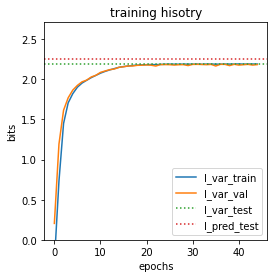

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x, y=y)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

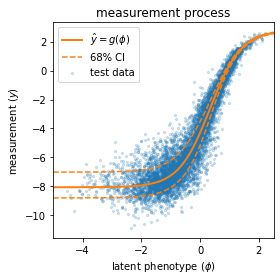

In [10]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

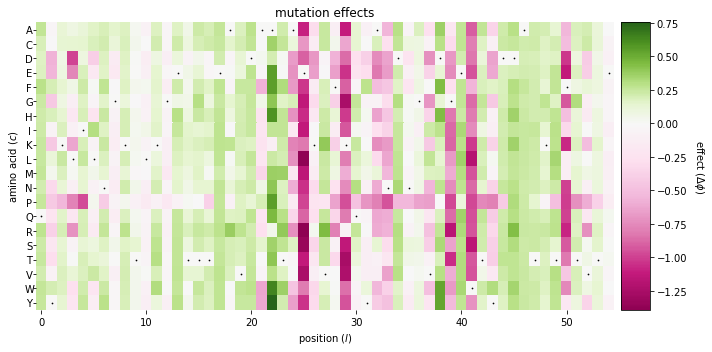

In [11]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
theta_dict = model.get_theta(gauge='user',
                             x_wt=gb1_seq)

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[10, 5])

# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
                        alphabet=theta_dict['alphabet'],
                        seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')

# Fix up plot
fig.tight_layout()
plt.show()


In [12]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

,set,yhat,phi,y,x
0,test,-4.207942,0.017278,-6.888361,QIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,0.397445,1.004454,0.274060,QYKLILNGHTLKGERTTEMVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,-1.951538,0.467866,-2.104813,QYKLRLNGKTLKGETTTEAVDACAAEKVFKQYANDNGVDGEWTYDP...
3,test,-7.682378,-1.435070,-7.625790,QYKLILNGKTLKGETTTEAVDNATAEKVFFQYANDNGVDGEWTYDD...
4,test,-5.519150,-0.294452,-5.505709,QYKLILNGRTLKGETTTEAVDAAVAEKVFKQYANDNGVDDEWTYDD...
